# Self‑Optimizing Control Analysis Tutorial

In this notebook we will:

1. **Import** required libraries  
2. **Define** the base Pyomo model  
3. **Implement** the self‑optimizing analysis routine  
4. **Specify** disturbance scenarios, CVs and metrics  
5. **Run** the analysis and **interpret** the results  


## 1. Setup and Imports

First, import the standard libraries, Pyomo and its solver interface, and Pandas/Numpy for data handling.


In [1]:
# Cell 1: Imports
import itertools
import numpy as np
import pandas as pd

import pyomo.environ as pyo
from pyomo.environ import value
from socf import run_self_optimizing_model

# For reproducibility (if needed):
np.random.seed(0)


## 2. Build the Base Model

#### The example taken for the current problem = 
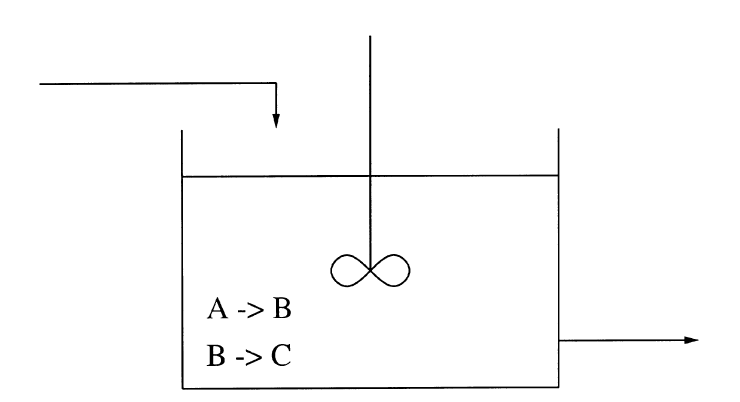

Define a function `build_base_model()` that returns a fresh `ConcreteModel`:
- 3 composition variables (Xa,Xb,Xc) bounded [0,1]  
- Hold‑up variable M ≥ 0  
- Mutable parameters Kb, F, Zb, Za, Ka  
- Mass‐balance constraints and the objective to maximize 100·Xb  




In [2]:
# Cell 2: Base‐Model Constructor
def build_base_model():
    """
    Returns a Pyomo ConcreteModel with:
    - Variables: Xa, Xb, Xc in [0,1], M ≥ 0
    - Params: Kb, F, Zb, Za (mutable), Ka
    - Mass‐balance constraints eq1, eq2, eq3
    - Objective J = 100*Xb (maximize)
    """
    m = pyo.ConcreteModel()
    # Variables
    m.Xa = pyo.Var(bounds=(0,1), initialize=0.4)
    m.Xb = pyo.Var(bounds=(0,1), initialize=0.2)
    m.Xc = pyo.Var(bounds=(0,1), initialize=0.4)
    m.M  = pyo.Var(bounds=(0,None), initialize=10)
    # Parameters
    m.Kb = pyo.Param(initialize=1.0, mutable=True)
    m.F  = pyo.Param(initialize=1.0, mutable=True)
    m.Zb = pyo.Param(initialize=0.0, mutable=True)
    m.Za = pyo.Param(initialize=0.8, mutable=True)
    m.Zc = pyo.Expression(expr=1 - m.Za)
    m.Ka = pyo.Param(initialize=1.0, mutable=True)
    # Constraints
    m.eq1 = pyo.Constraint(expr= m.Za*m.F - m.Xa*m.F - m.Ka*m.Xa*m.M == 0)
    m.eq2 = pyo.Constraint(expr= m.Zb*m.F - m.Xb*m.F + m.Ka*m.Xa*m.M - m.Kb*m.Xb*m.M == 0)
    m.eq3 = pyo.Constraint(expr= m.Xc == 1 - m.Xa - m.Xb)
    # Objective
    m.J = pyo.Objective(expr=100*m.Xb, sense=pyo.maximize)
    return m


## 3. Self‑Optimizing Analysis Function

This function loops over:
- **Nominal & single‑factor** disturbance scenarios  
- **User‑defined designs** (fixing or constraining CVs)  
- **Metrics** collected from each solve  

It returns a DataFrame of controlled‑variable values and a loss‑matrix ranking each design.


## 4. Define Scenarios, Designs & Metrics

Here we set:

- **disturbances**: which parameter values to sweep  
- **Controlled_Variables**: design rules (fix/constraint)  
- **CVs**: what metrics to extract from each solve  


In [3]:
# Cell 4: Problem Setup

disturbances = {
    "F":  [1.0, 0.7],
    "Za": [0.8, 0.6, 1.0],
    "Ka": [1.0, 1.5],
    "Kb": [1.0, 1.5],
}

Controlled_Variables = {
    "M=1.0":       lambda m: m.M.fix(1.0),
    "M/F=1.0":     lambda m: m.add_component("mf_eq", pyo.Constraint(expr=m.M == m.F)),
    "Xa=0.4":      lambda m: m.Xa.fix(0.4),
    "Xb=0.2":      lambda m: m.Xb.fix(0.2),
    "Xc=0.4":      lambda m: m.Xc.fix(0.4),
    "Xb/Xa=0.5":   lambda m: m.add_component("ratio", pyo.Constraint(expr=m.Xb == 0.5*m.Xa)),
    "Xa+2Xb+3Xc=2.0": lambda m: m.add_component("t1", pyo.Constraint(expr=m.Xa+2*m.Xb+3*m.Xc==2.0)),
    "Xa+3Xb+2Xc=1.8": lambda m: m.add_component("t2", pyo.Constraint(expr=m.Xa+3*m.Xb+2*m.Xc==1.8)),
}

CVs = {
    "J":     lambda m,c: value(m.J),
    "M":     lambda m,c: value(m.M),
    "M/F":   lambda m,c: value(m.M)/c['F'],
    "xA":    lambda m,c: value(m.Xa),
    "xB":    lambda m,c: value(m.Xb),
    "xC":    lambda m,c: value(m.Xc),
    "xB/xA": lambda m,c: (value(m.Xb)/value(m.Xa)) if value(m.Xa) else np.nan,
    "θ1":    lambda m,c: value(m.Xa)+2*value(m.Xb)+3*value(m.Xc),
    "θ2":    lambda m,c: value(m.Xa)+3*value(m.Xb)+2*value(m.Xc),
}


## 5. Run & Display Results

Finally, call the routine and neatly print the results.


In [4]:
# Cell 5: Execute Analysis
if __name__ == "__main__":
    results_df, loss_matrix = run_self_optimizing_model(
        build_base_model,
        disturbances,
        Controlled_Variables,
        CVs
    )

    print("=== Optimal CVs under each disturbance ===")
    display(results_df)     
    print("\n=== Loss for alternative controlled variables ===")
    display(loss_matrix)


model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.17\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.17\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
=== Optimal CVs under each disturbance ===


C:\Users\Saket\Documents\socf-project\src\socf\core.py:164: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric = loss_matrix.replace("infeasible", np.nan).apply(pd.to_numeric)


,Nominal,Kb=1.5,Ka=1.5,Za=0.6,Za=1.0,F=0.7
J,20.0,16.1633,24.2449,15.00,25.00,20.0
M,1.0,0.8165,0.8165,1.00,1.00,0.7
M/F,1.0,0.8165,0.8165,1.00,1.00,1.0
xA,0.4,0.4404,0.3596,0.30,0.50,0.4
xB,0.2,0.1616,0.2424,0.15,0.25,0.2
xC,0.4,0.3980,0.3980,0.55,0.25,0.4
xB/xA,0.5,0.3670,0.6742,0.50,0.50,0.5
θ1,2.0,1.9576,2.0384,2.25,1.75,2.0
θ2,1.8,1.7212,1.8829,1.85,1.75,1.8



=== Loss for alternative controlled variables ===


,Loss with M=1.0,Loss with M/F=1.0,Loss with Xa=0.4,Loss with Xb=0.2,Loss with Xc=0.4,Loss with Xb/Xa=0.5,Loss with Xa+2Xb+3Xc=2.0,Loss with Xa+3Xb+2Xc=1.8
Nominal,0.0,0.0,0.0,infeasible,0.0,0.0,0.0,0.0
Kb=1.5,0.16,0.16,0.16,infeasible,0.0,2.83,0.04,0.72
Ka=1.5,0.24,0.24,0.24,infeasible,0.0,1.39,0.06,0.82
Za=0.6,0.0,0.0,1.67,infeasible,15.0,0.0,3.35,0.36
Za=1.0,0.0,0.0,1.0,infeasible,1.75,0.0,1.39,0.28
F=0.7,0.62,0.0,0.0,infeasible,0.0,0.0,0.0,0.0
Average loss,0.17,0.07,0.51,NaN,2.79,0.7,0.81,0.36
Ranking,2.0,1.0,4.0,8.0,7.0,5.0,6.0,3.0


### Interpretation

- **Results table** (`results_df`): shows, e.g., how M, xB/xA, θ₁,… vary when Za or F change  
- **Loss matrix**: ranks each CV‑design by average loss (row “Average loss” and “Ranking”)  
- **Infeasible designs** are marked and pushed to the bottom of the ranking.  
